## What is my goal with this project?
As a citizen of Porto Alegre for more than 25 years I started to have the feeling that our weather is changing a little on these last years. Out of curiosity I wanted to visualize what differences are perceptible.

This is a simple project intended only to consolidate my knowledge of pandas, matplotlib and seaborn as I'm currently deepening my comprehension of them.

### Dataset index & columns
0. date: from 2001-01-01 to 2022-03-10. As index.
1. total_precip: daily total precipitation.
2. max_temp: daily maximum temperature.
3. avg_temp: daily average temperature.
4. min_temp: daily minimum temperature.
5. avg_humidity: daily average humidity.
6. min_humidity: daily minimum humidity.

### What steps will be done:
* Data extraction: load .csv
* Data preparation: clean useless cols & rows, simplify & translate cols, convert data types, decrease the amount of NaN, date as index, drop NaN
* Visualization: 

### Which questions I want to answer?

#### Summer

* Did the avg temp rose up in these last years?
* Did the max temp rose up?

#### Winter

* Did the mean temperature had any change?
* Did the min temperature decreased?

#### Precipitation

* Did the monthly precipitations sums had suffered some kind of change trough the years?

#### Humidity

* Did the humidity monthly means suffered any changes along these years? Does it follows the changes of other variables?

In [78]:
import numpy as np
import pandas as pd
import datetime

## Data extraction
I got this .csv file with historical data from Porto Alegre from the INMET (Instituto Nacional de Meteorologia) website. It's very simple to get the data in the way you want (specific variables, date range, etc). You can go to https://bdmep.inmet.gov.br/ (the INMET database website) and ask for it, it gives you many options to customise your data and the dataset will be sent via e-mail.

In [79]:
# [Po]rto [A]legre [W]eather dataframe being loaded from the csv with ';' as separator
poaw = pd.read_csv('DATA_POA_2001-01-01_2022-03-11.csv',sep=';')
poaw.head()

,Data Medicao,"PRECIPITACAO TOTAL, DIARIO (mm)","TEMPERATURA MAXIMA, DIARIA (C)","TEMPERATURA MEDIA, DIARIA (C)","TEMPERATURA MINIMA, DIARIA (C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (%)",Unnamed: 7
0,2001-01-01,0,"30,1","23,616667","18,4","68,458333",48.0,NaN
1,2001-01-02,0,"32,1","25,475",20,"69,958333",45.0,NaN
2,2001-01-03,0,"33,4","26,345833",21,"69,083333",43.0,NaN
3,2001-01-04,0,"35,5","27,429167","21,2","65,041667",37.0,NaN
4,2001-01-05,0,"35,6","27,6375","24,6","67,25",35.0,NaN


## Data preparation
What will be done:
* Drop the useless cols
* Simplify and translate cols names
* Convert str data types to datetime (date) and to float (others)

#### Drop the useless cols

In [80]:
# Drop the last and useless column
poaw.drop(labels='Unnamed: 7',axis=1,inplace=True)

#### Simplify and translate cols names

In [81]:
# For simplification and translation purposes I will change the columns names
new_col_names = ['date',
                 'total_precip',
                 'max_temp','avg_temp',
                 'min_temp',
                 'avg_humidity',
                 'min_humidity']

poaw.columns = new_col_names

#### Convert str data types to datetime (date) and to float (others)

In [82]:
# Convert the "Date" col to datetime type and the other cols to float type (the last col is already float)
poaw['date'] = pd.to_datetime(poaw['date'])

# List with all the cols to be changed from str to float
cols_to_float = ['total_precip', 'max_temp', 'avg_temp', 'min_temp', 'avg_humidity']

poaw[cols_to_float] = poaw[cols_to_float].apply(lambda x: x.str.replace(',','.').astype(float))

#Non used trash
#poaw['Max Temp'] = poaw.iloc[:,2:3].apply(lambda x: x.str.replace(',','.').astype(float))
#poaw['Average Temp'] = poaw.iloc[:,3:4].apply(lambda x: x.str.replace(',','.').astype(float))
#poaw['Min Temp'] = poaw.iloc[:,4:5].apply(lambda x: x.str.replace(',','.').astype(float))
#poaw['Avg Relative Humidity'] = poaw.iloc[:,5:6].apply(lambda x: x.str.replace(',','.').astype(float))

#### Decrease the amount of NaN
In an attempt to decrease the amount of NaN and trying to lose the least amount of rows, I try to make the average from min and max temperature and replace the NaN of the avg_temp with it, in the cols where I have min & max temp but not avg.

In [83]:
poaw.isna().sum()

date              0
total_precip    530
max_temp        292
avg_temp        508
min_temp        287
avg_humidity    211
min_humidity    112
dtype: int64

In [84]:
# Here I look for the rows which avg_temp is NaN and that max_temp & min_temp exists
# From this I replace the NaN with the arithmetic mean between max and min temperatures
poaw.loc[poaw['max_temp'].notnull() 
         & poaw['min_temp'].notnull() 
         & poaw['avg_temp'].isnull(),'avg_temp'] = (poaw['max_temp'] + poaw['min_temp']) / 2

poaw.isna().sum()

date              0
total_precip    530
max_temp        292
avg_temp        314
min_temp        287
avg_humidity    211
min_humidity    112
dtype: int64

#### Set date as index & Dropping non-useful rows
As I don't plan right now on applying ML models on this dataset the best choice for the rows that contain too mmany NaNs is to drop it commpletely

In [85]:
#Setting the date as index
poaw.set_index('date',inplace=True)

#Droping rows where there are at least 4 non-NaN
poaw.dropna(thresh=4, inplace=True)

In [86]:
poaw.isna().sum()

total_precip    229
max_temp         13
avg_temp         12
min_temp         22
avg_humidity      0
min_humidity     25
dtype: int64

In [87]:
## used for getting the % of NAs
## poaw['avg_temp'].value_counts(normalize=True,dropna=False)

In [29]:
## null_list = poaw[poaw['avg_temp'].isnull()].index.tolist()
## filled = poaw[['max_temp','avg_temp','min_temp']].fillna(method='ffill')

## Visualizing

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")

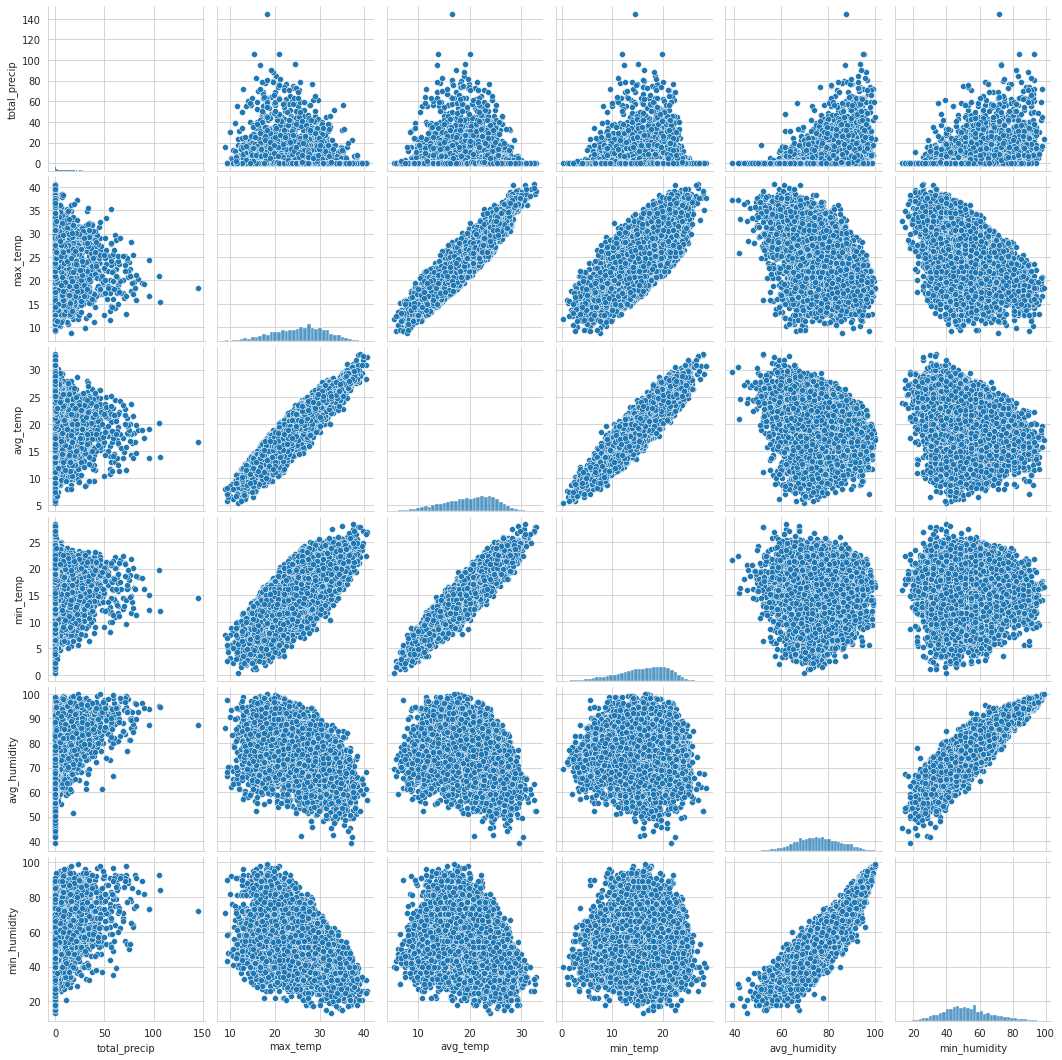

In [90]:
sns.pairplot(poaw)

In [49]:
by_year = poaw.groupby(pd.Grouper(key='date',freq='Y')).mean()

<AxesSubplot:xlabel='date'>

<Figure size 864x576 with 0 Axes>

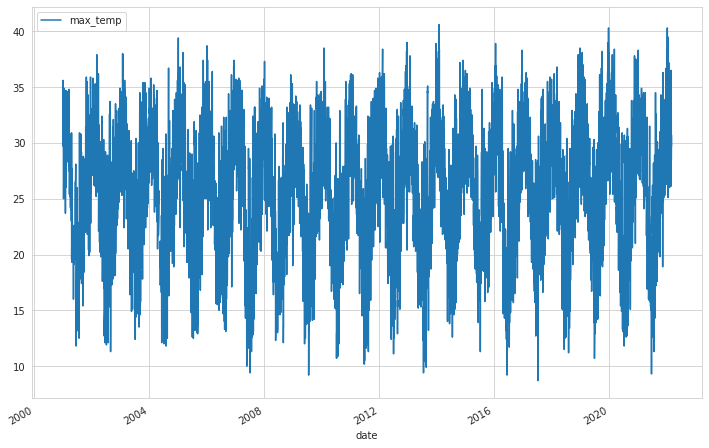

In [91]:
plt.figure(figsize=(12,8))
poaw.plot(y='max_temp',figsize=(12,8))

In [92]:
#Separating by summers, winters and years (in the south hemisphere)
summer_start, summer_end = '-12-21', '-03-20'
winter_start, winter_end = '-05-21', '-09-22'
year_start, year_end = '-01-01', '-12-31'


#Initializing with 0 to make the index of years to reflect it's year
summers = [0]
winters = [0]
years = [0]

year = 2000

for i in range(1,23):
    
    year_i = str(year + i)
    
    summers.append(poaw.loc[year_i + summer_start:str(year+i+1) + summer_end]) #Correction because the summer ends in the next year
    winters.append(poaw.loc[year_i + winter_start:year_i + winter_end])
    years.append(poaw.loc[year_i + year_start:year_i + year_end])


In [93]:
summers[21]

,total_precip,max_temp,avg_temp,min_temp,avg_humidity,min_humidity
date,,,,,,
2021-12-21,0.0,31.4,24.758333,20.7,75.625000,38.0
2021-12-22,0.2,28.6,24.454167,22.1,71.083333,45.0
2021-12-23,0.0,27.9,22.870833,18.1,67.458333,49.0
2021-12-24,0.0,29.3,23.037500,18.1,66.583333,36.0
2021-12-25,0.0,32.6,24.175000,17.7,65.583333,23.0
...,...,...,...,...,...,...
2022-03-06,0.8,32.6,25.100000,23.8,85.333333,60.0
2022-03-07,56.4,35.2,25.170833,21.1,82.416667,51.0
2022-03-08,5.0,28.5,23.954167,20.9,80.416667,61.0


In [94]:
poaw.loc[('2001-12-21'):('2001'+summer_end)]

,total_precip,max_temp,avg_temp,min_temp,avg_humidity,min_humidity
date,,,,,,


<AxesSubplot:xlabel='date'>

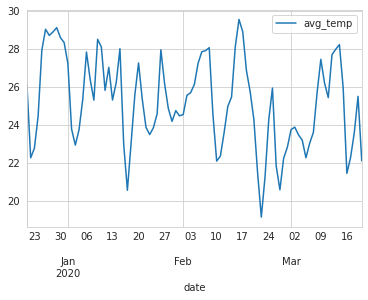

In [95]:
summers[19].plot(y='avg_temp')

Text(0, 0.5, 'Temperature C')

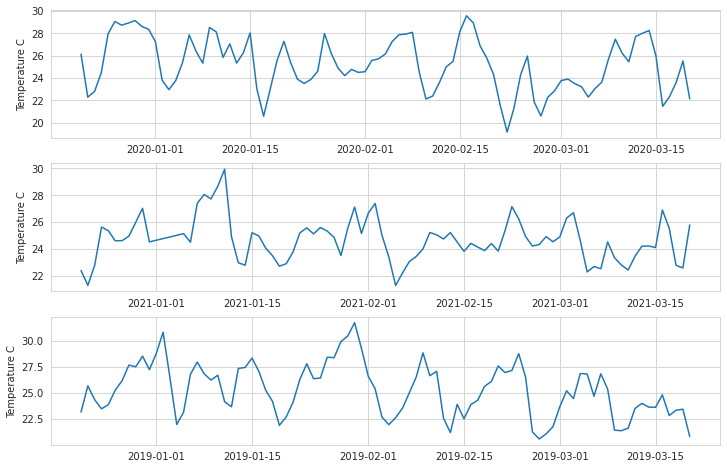

In [98]:
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(summers[19]['avg_temp'])
plt.ylabel('Temperature C')    

plt.subplot(3,1,2)
plt.plot(summers[20]['avg_temp'])
plt.ylabel('Temperature C')

plt.subplot(3,1,3)
plt.plot(summers[18]['avg_temp'])
plt.ylabel('Temperature C')